In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from astropy import units as u
import astropy.coordinates as coord
from mpl_toolkits import mplot3d
from sklearn.datasets import make_blobs
import seaborn as sns
import hdbscan
import math
import itertools
import pickle
from sklearn.preprocessing import StandardScaler

plt.style.use('science')

import time

OSError: 'science' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [48]:
#we make a function from all the other data
def ClusterAndCrossmatch(field, clust_mean, clust, clustername, doclust):
    clust_mean = clust_mean.query(f'oc == "{clustername}"')
    clust = clust.query(f'cluster == "{clustername}"')
    magnitudecut = np.arange(12, np.max(clust['phot_g_mean_mag']) +1)
    field = field.query(f'phot_g_mean_mag < {np.max(magnitudecut)}').dropna().query('0 < parallax < 7').query('-30 < pmra < 30').query('-30 < pmdec < 30')

    #make the 4 plots

    plt.figure(figsize=(12,12))
    #plot 1, ra and dec
    plt.subplot(2,2,1)
    plt.scatter(field['ra'], field['dec'], c='grey', s = 0.1 , alpha=0.1)
    plt.scatter(clust['ra'], clust['dec'], c = 'blue')
    plt.xlabel('RA')
    plt.ylabel('Dec')

    #plot 2, pmra and pmdec
    plt.subplot(2,2,2)
    plt.scatter(field['pmra'], field['pmdec'], c='grey', s = 1 , alpha=0.5)
    plt.scatter(clust['pmra'], clust['pmdec'], c = 'blue')
    plt.xlim((clust_mean['medPmra'] - 10*clust_mean['sigPmra']).min(), (clust_mean['medPmra'] + 10*clust_mean['sigPmra']).max())
    plt.ylim((clust_mean['medPmdec'] - 10*clust_mean['sigPmdec']).min(), (clust_mean['medPmdec'] + 10*clust_mean['sigPmdec']).max())
    plt.xlabel('pmra')
    plt.ylabel('pmdec')

    #plot 3, parallax and G
    plt.subplot(2,2,3)
    plt.scatter(field['phot_g_mean_mag'], field['parallax'], c='grey', s = 1 , alpha=0.5)
    plt.scatter(clust['phot_g_mean_mag'], clust['parallax'], c = 'blue')
    plt.ylim(0, np.max(clust['parallax']) + 1)
    plt.xlabel('G')
    plt.ylabel('Parallax')

    #plot 4, bp_rp and G
    plt.subplot(2,2,4)
    plt.scatter(field['bp_rp'], field['phot_g_mean_mag'], c='grey', s = 1 , alpha=0.5)
    plt.scatter(clust['bp_rp'], clust['phot_g_mean_mag'], c = 'blue')
    plt.ylim(10,np.ceil(np.max(magnitudecut)))
    plt.xlim(-0.5,3)
    plt.xlabel('BP-RP')
    plt.ylabel('G')
    plt.gca().invert_yaxis()
    plt.show()

    #now cluster and crossmatch

    purityarray = np.array([])
    completenessarray = np.array([])
    


    for i in magnitudecut:
        print(f'G <= {i}')
        cutfield = field.query(f'phot_g_mean_mag < {i}')
        clust_ID = np.array(clust.query(f'phot_g_mean_mag <={i}')['source_id'])
        field_ID = np.array(cutfield['source_id'])
        print(f'\tOC members: {len(clust_ID)}')
        print(f'\tField stars: {len(cutfield)}')
        
        #scale the data
        data_scaled = StandardScaler().fit_transform(np.array(cutfield[['ra', 'dec', 'parallax', 'pmra', 'pmdec']]))
        scaled_frame = pd.DataFrame(data_scaled, columns = ['ra', 'dec', 'parallax', 'pmra', 'pmdec'], dtype=float)
        
        #determine a minimum cluster size and cluster the data, or load the data
        if doclust == True:
            clustersize = min(10, len(clust.query(f'phot_g_mean_mag<= {i}')))
            clusterer = hdbscan.HDBSCAN(min_cluster_size=clustersize, min_samples=clustersize, cluster_selection_method = 'leaf')
            clusterer.fit(scaled_frame)

            #save the clusterer
            with open(f'Data\\{clustername}\\clusterer\\clusterer_{clustername}_mag{i}.pkl', 'wb') as f:
                pickle.dump(clusterer, f)
       
        elif doclust == False:
            with open(f'Data\\{clustername}\\clusterer\\clusterer_{clustername}_mag{i}.pkl', 'rb') as f:
                clusterer = pickle.load(f)
        print(f'\t# HDBscan Groups: {len(np.unique(clusterer.labels_))-1}')

        #crossmatch the data and calculate purity and completeness
        

        complete_crossmatch = np.array([])
        group_members = np.array([])
        for j in np.unique(clusterer.labels_):
            if j == -1: continue
            group_index = clusterer.labels_ == j
            matchedgroup = cutfield[['source_id', 'phot_g_mean_mag', 'bp_rp']][group_index]
            group_ID = np.array(cutfield['source_id'][group_index])
            crossmatch = np.array([True if x in clust_ID else False for x in group_ID])

            #make sure to not get an error if there are no members in the group
            if np.sum(crossmatch) > 0:
                members = len(group_ID)
                crossmatch_amount = np.sum(crossmatch)
                print(f'\t\tGroup {j}:')
                print(f'\t\t\t # members: {members}')
                print(f'\t\t\t # crossmatched stars: {crossmatch_amount}')
                complete_crossmatch = np.append(complete_crossmatch, crossmatch_amount)
                group_members = np.append(group_members, members)
                #plot for the highest magnitude the cmd's of the clusters and the groups
                if i == np.max(magnitudecut):
                    phot_G = matchedgroup['phot_g_mean_mag']
                    color = matchedgroup['bp_rp']
                    plt.scatter(field['bp_rp'], field['phot_g_mean_mag'], c='grey', s = 1 , alpha=0.5)
                    plt.scatter(clust['bp_rp'], clust['phot_g_mean_mag'], c = 'blue', label = 'cluster members')
                    plt.scatter(color, phot_G, c = 'red', label = 'group members')
                    plt.ylim(10,np.ceil(np.max(magnitudecut)))
                    plt.xlim(-0.5,3)
                    plt.xlabel('BP-RP')
                    plt.ylabel('G')
                    plt.gca().invert_yaxis()
                    plt.show()



            elif np.sum(crossmatch) == 0:
                complete_crossmatch = np.append(complete_crossmatch, 0)
        



        crossmatched_total = np.sum(complete_crossmatch)
        total_members = np.sum(group_members)
        
        #make sure that there are no errors if there are no members in the cluster (note that purity is the homogeneity but with multiple groups that sometimes have to be combined i didn't want to call it homogeneity)
        if total_members == 0:
            purity = 0
        else:
            purity = crossmatched_total/total_members
        completeness = crossmatched_total/len(clust_ID)
        print(total_members)

        purityarray = np.append(purityarray, purity)
        completenessarray = np.append(completenessarray, completeness)
        print(f'\tPurity: {purity}')
        print(f'\tCompleteness: {completeness}')

    #return the arrays for the purity and completeness so that we can plot them
    return purityarray, completenessarray

    

In [3]:
#import all the data

field_UBC21 = pd.read_csv('Data\\UBC21-result.csv')
field_COIN = pd.read_csv('Data\\COIN-result.csv')
field_Platais10 = pd.read_csv('Data\\Platais-result.csv')
field_UBC14 = pd.read_csv('Data\\UBC14-result.csv')
field_UBC13 = pd.read_csv('Data\\UBC13-result.csv')

field_UPK495 = pd.read_csv('Data\\UPK_495-result.csv')
field_UPK533 = pd.read_csv('Data\\UPK533-result.csv')

#Special Case for UPK654, I will explain in the report
UPK654second = pd.read_csv('Data\\SecondUPK654-result.csv')
UPK654first = pd.read_csv('Data\\FirstUPK654-result.csv')

field_UPK654 = pd.concat([UPK654first, UPK654second])


mean_dr3 = pd.read_csv('Data\\oc_means_dr3.csv')
memb_dr3 = pd.read_csv('Data\\members_kept_2681_OCs.csv')

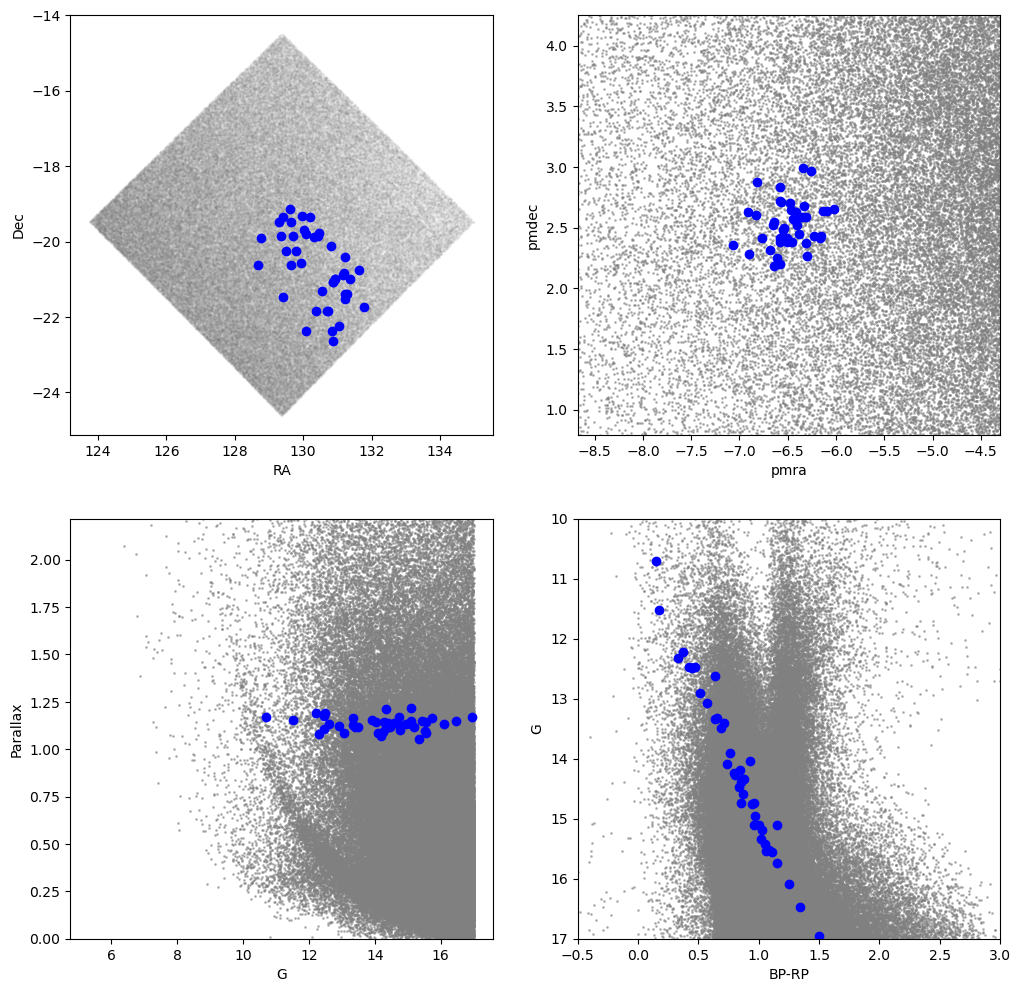

G <= 12.0
	OC members: 2
	Field stars: 5328
	# HDBscan Groups: 638
		Group 394:
			 # members: 3
			 # crossmatched stars: 1
3.0
	Purity: 0.3333333333333333
	Completeness: 0.5
G <= 13.0
	OC members: 9
	Field stars: 12771
	# HDBscan Groups: 21
		Group 0:
			 # members: 10
			 # crossmatched stars: 3
10.0
	Purity: 0.3
	Completeness: 0.3333333333333333
G <= 14.0
	OC members: 15
	Field stars: 28609
	# HDBscan Groups: 15
0.0
	Purity: 0
	Completeness: 0.0
G <= 15.0
	OC members: 29
	Field stars: 61386
	# HDBscan Groups: 51
		Group 0:
			 # members: 18
			 # crossmatched stars: 9
		Group 1:
			 # members: 31
			 # crossmatched stars: 10
49.0
	Purity: 0.3877551020408163
	Completeness: 0.6551724137931034
G <= 16.0
	OC members: 39
	Field stars: 126855
	# HDBscan Groups: 73
		Group 1:
			 # members: 48
			 # crossmatched stars: 16
		Group 3:
			 # members: 12
			 # crossmatched stars: 7
60.0
	Purity: 0.38333333333333336
	Completeness: 0.5897435897435898
G <= 17.0
	OC members: 42
	Field stars: 2379

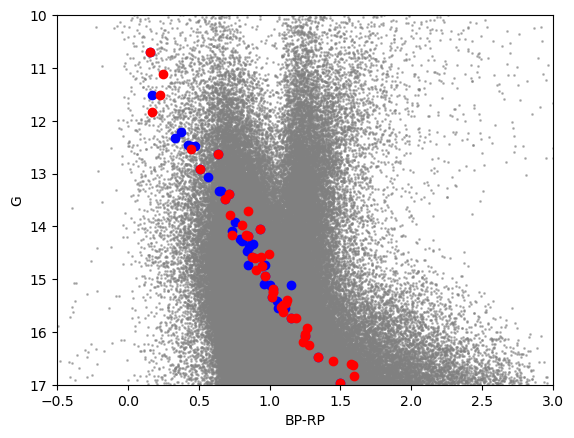

		Group 6:
			 # members: 14
			 # crossmatched stars: 4


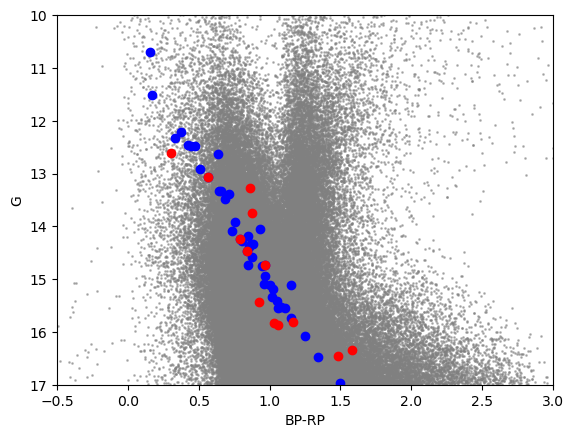

60.0
	Purity: 0.35
	Completeness: 0.5


In [55]:
purity21, completeness21 = ClusterAndCrossmatch(field_UBC21, mean_dr3, memb_dr3, 'UBC_21', doclust=False)


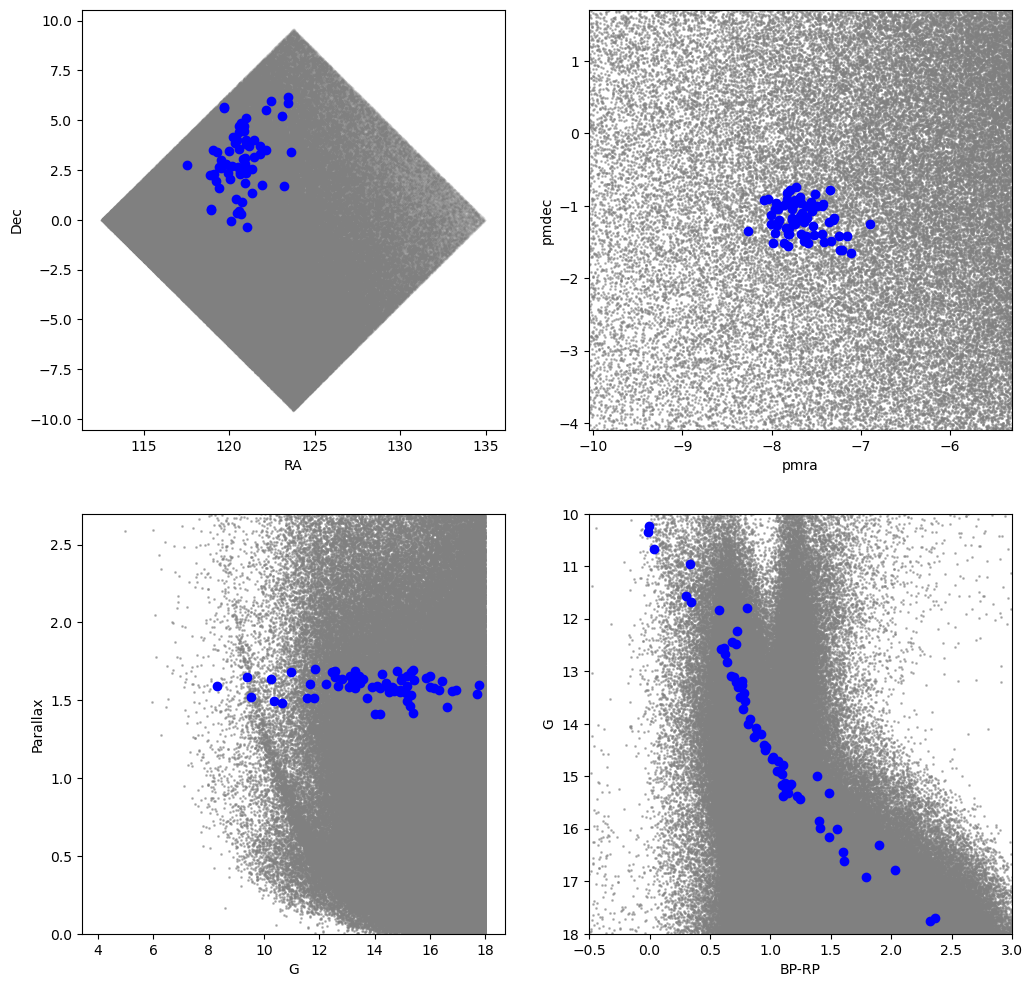

G <= 12.0
	OC members: 11
	Field stars: 16640
	# HDBscan Groups: 19
		Group 1:
			 # members: 14
			 # crossmatched stars: 4
14.0
	Purity: 0.2857142857142857
	Completeness: 0.36363636363636365
G <= 13.0
	OC members: 18
	Field stars: 38123
	# HDBscan Groups: 28
		Group 2:
			 # members: 16
			 # crossmatched stars: 2
		Group 6:
			 # members: 10
			 # crossmatched stars: 3
		Group 7:
			 # members: 16
			 # crossmatched stars: 6
42.0
	Purity: 0.2619047619047619
	Completeness: 0.6111111111111112
G <= 14.0
	OC members: 30
	Field stars: 81724
	# HDBscan Groups: 43
		Group 2:
			 # members: 23
			 # crossmatched stars: 1
		Group 5:
			 # members: 16
			 # crossmatched stars: 4
		Group 6:
			 # members: 39
			 # crossmatched stars: 17
78.0
	Purity: 0.28205128205128205
	Completeness: 0.7333333333333333
G <= 15.0
	OC members: 45
	Field stars: 170750
	# HDBscan Groups: 84
		Group 5:
			 # members: 22
			 # crossmatched stars: 2
		Group 10:
			 # members: 12
			 # crossmatched stars: 4
		Group 1

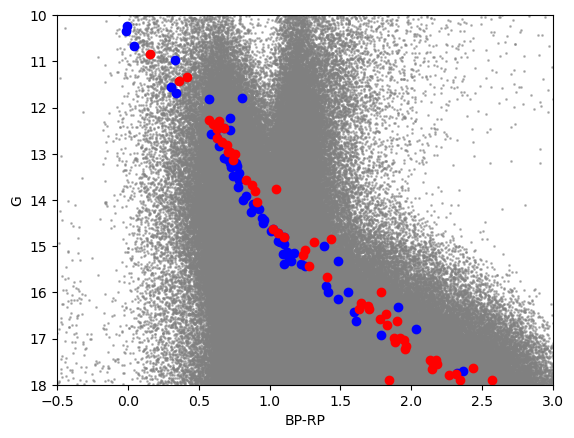

		Group 33:
			 # members: 11
			 # crossmatched stars: 3


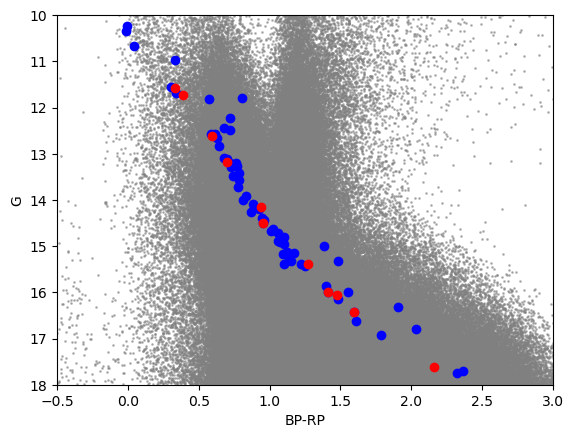

		Group 34:
			 # members: 24
			 # crossmatched stars: 18


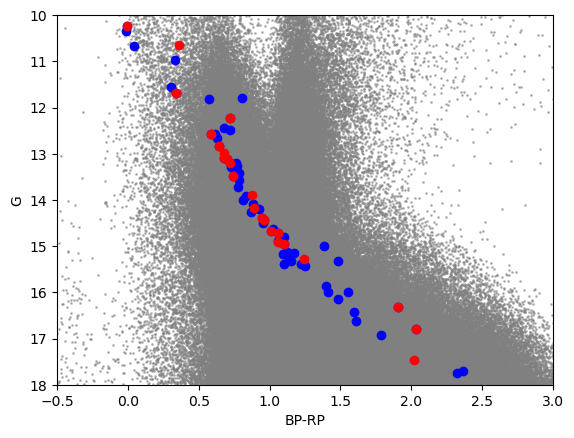

95.0
	Purity: 0.2631578947368421
	Completeness: 0.3787878787878788


In [50]:
purity13, completeness13 = ClusterAndCrossmatch(field_UBC13, mean_dr3, memb_dr3, 'UBC_13', doclust=False)


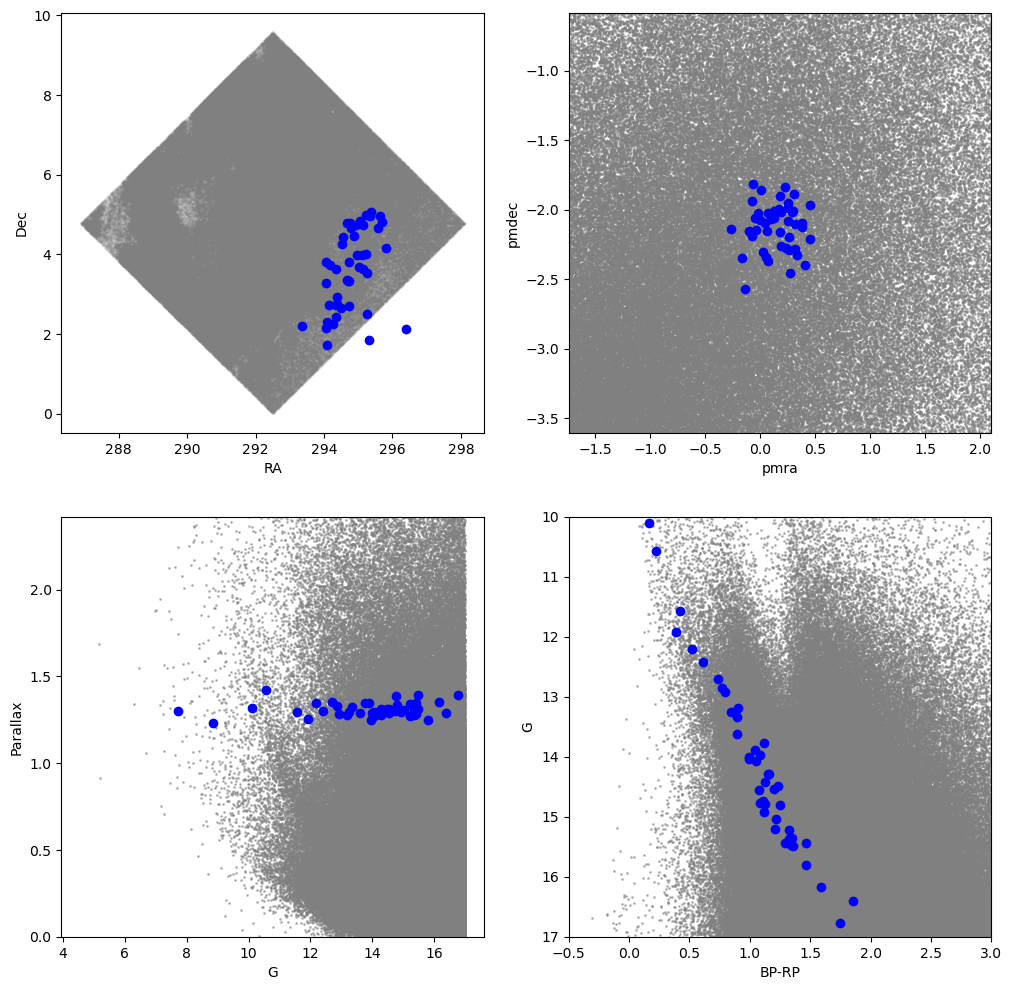

G <= 12.0
	OC members: 6
	Field stars: 8827
	# HDBscan Groups: 18
0.0
	Purity: 0
	Completeness: 0.0
G <= 13.0
	OC members: 11
	Field stars: 25800
	# HDBscan Groups: 22
		Group 0:
			 # members: 20
			 # crossmatched stars: 3
		Group 1:
			 # members: 29
			 # crossmatched stars: 5
49.0
	Purity: 0.16326530612244897
	Completeness: 0.7272727272727273
G <= 14.0
	OC members: 18
	Field stars: 67522
	# HDBscan Groups: 61
		Group 0:
			 # members: 42
			 # crossmatched stars: 5
		Group 1:
			 # members: 11
			 # crossmatched stars: 4
53.0
	Purity: 0.16981132075471697
	Completeness: 0.5
G <= 15.0
	OC members: 32
	Field stars: 165029
	# HDBscan Groups: 130
		Group 1:
			 # members: 13
			 # crossmatched stars: 5
		Group 2:
			 # members: 59
			 # crossmatched stars: 12
72.0
	Purity: 0.2361111111111111
	Completeness: 0.53125
G <= 16.0
	OC members: 42
	Field stars: 378376
	# HDBscan Groups: 254
		Group 5:
			 # members: 16
			 # crossmatched stars: 5
		Group 6:
			 # members: 65
			 # crossmatched

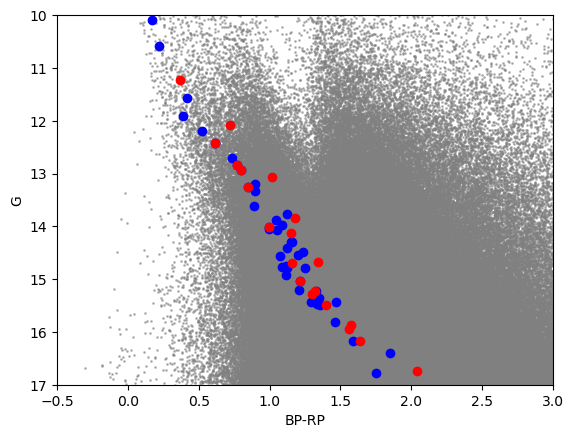

		Group 7:
			 # members: 10
			 # crossmatched stars: 4


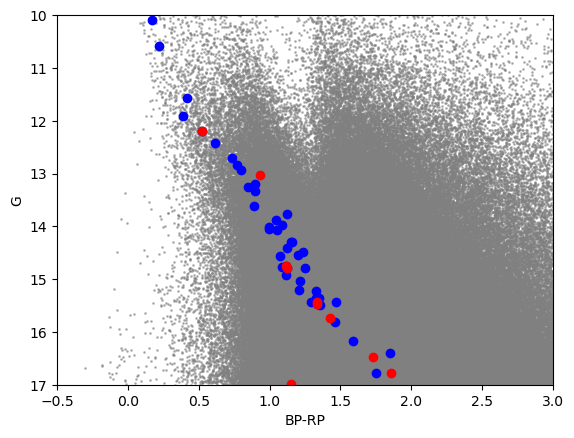

32.0
	Purity: 0.3125
	Completeness: 0.2222222222222222


In [51]:
purity14, completeness14 = ClusterAndCrossmatch(field_UBC14, mean_dr3, memb_dr3, 'UBC_14', doclust=False)

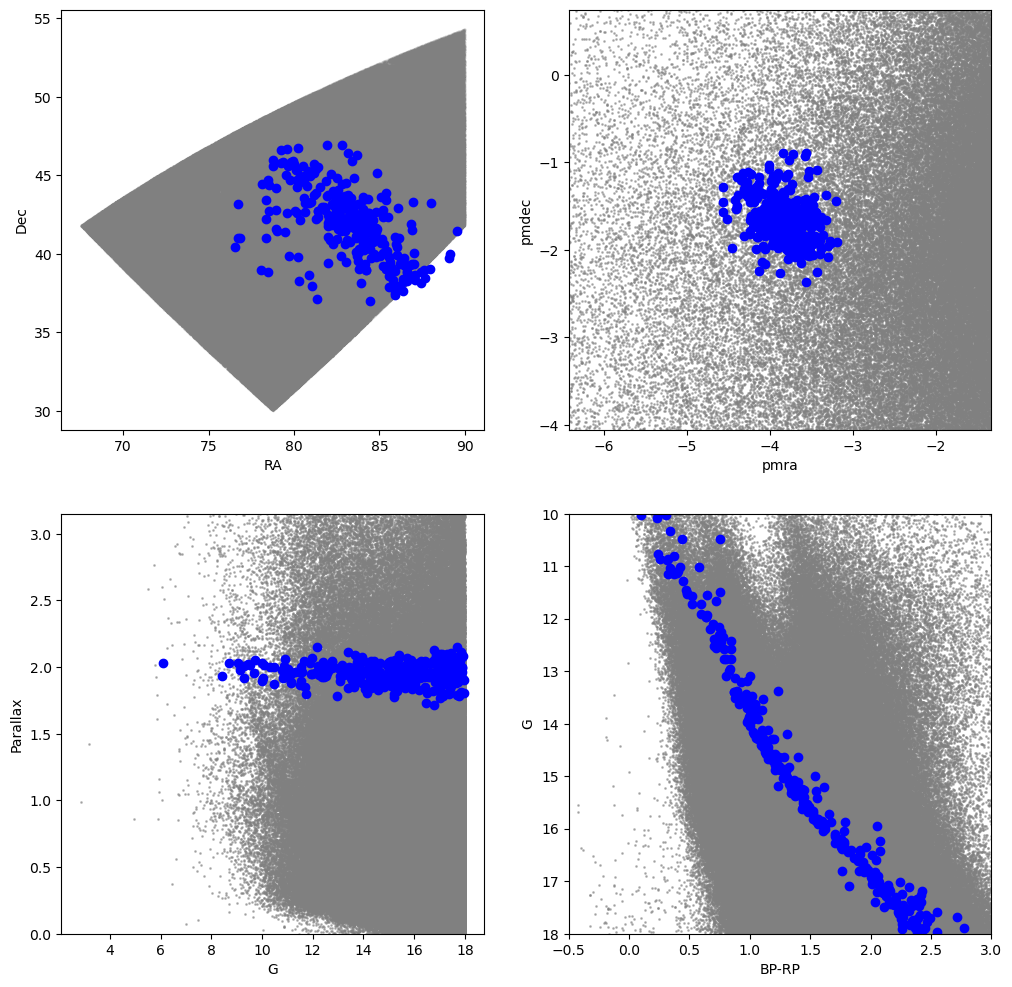

G <= 12.0
	OC members: 44
	Field stars: 24071
	# HDBscan Groups: 45
		Group 4:
			 # members: 10
			 # crossmatched stars: 2
		Group 6:
			 # members: 37
			 # crossmatched stars: 27
47.0
	Purity: 0.6170212765957447
	Completeness: 0.6590909090909091
G <= 13.0
	OC members: 66
	Field stars: 58693
	# HDBscan Groups: 87
		Group 3:
			 # members: 14
			 # crossmatched stars: 5
		Group 4:
			 # members: 66
			 # crossmatched stars: 44
80.0
	Purity: 0.6125
	Completeness: 0.7424242424242424
G <= 14.0
	OC members: 108
	Field stars: 136084
	# HDBscan Groups: 179
		Group 11:
			 # members: 18
			 # crossmatched stars: 9
		Group 12:
			 # members: 105
			 # crossmatched stars: 70
123.0
	Purity: 0.6422764227642277
	Completeness: 0.7314814814814815
G <= 15.0
	OC members: 157
	Field stars: 295288
	# HDBscan Groups: 339
		Group 12:
			 # members: 134
			 # crossmatched stars: 108
		Group 13:
			 # members: 18
			 # crossmatched stars: 11
152.0
	Purity: 0.7828947368421053
	Completeness: 0.7579617834394

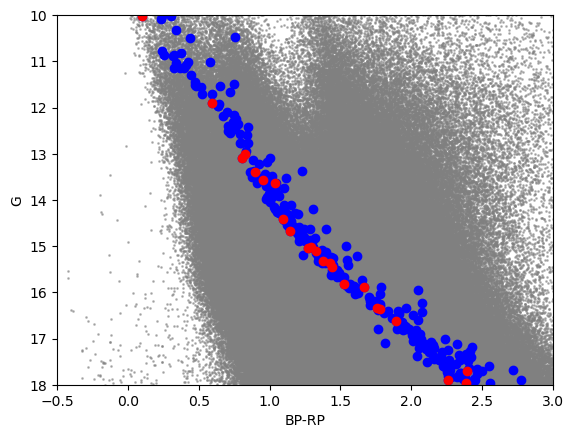

		Group 50:
			 # members: 23
			 # crossmatched stars: 19


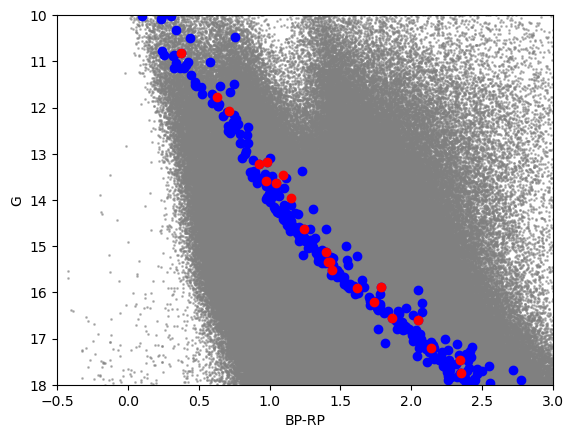

		Group 51:
			 # members: 127
			 # crossmatched stars: 123


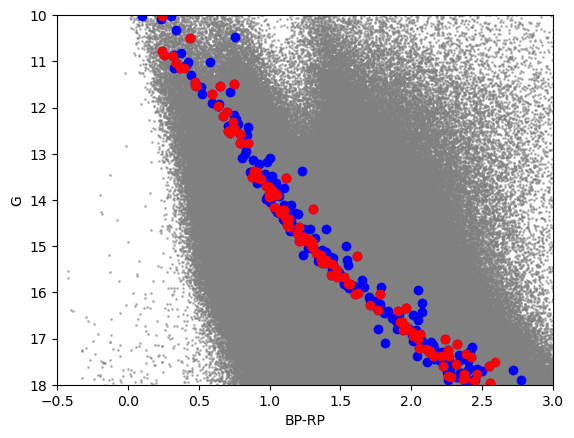

173.0
	Purity: 0.953757225433526
	Completeness: 0.5061349693251533


In [52]:
purityCOIN, completenessCOIN = ClusterAndCrossmatch(field_COIN, mean_dr3, memb_dr3, 'COIN-Gaia_13', doclust=False)

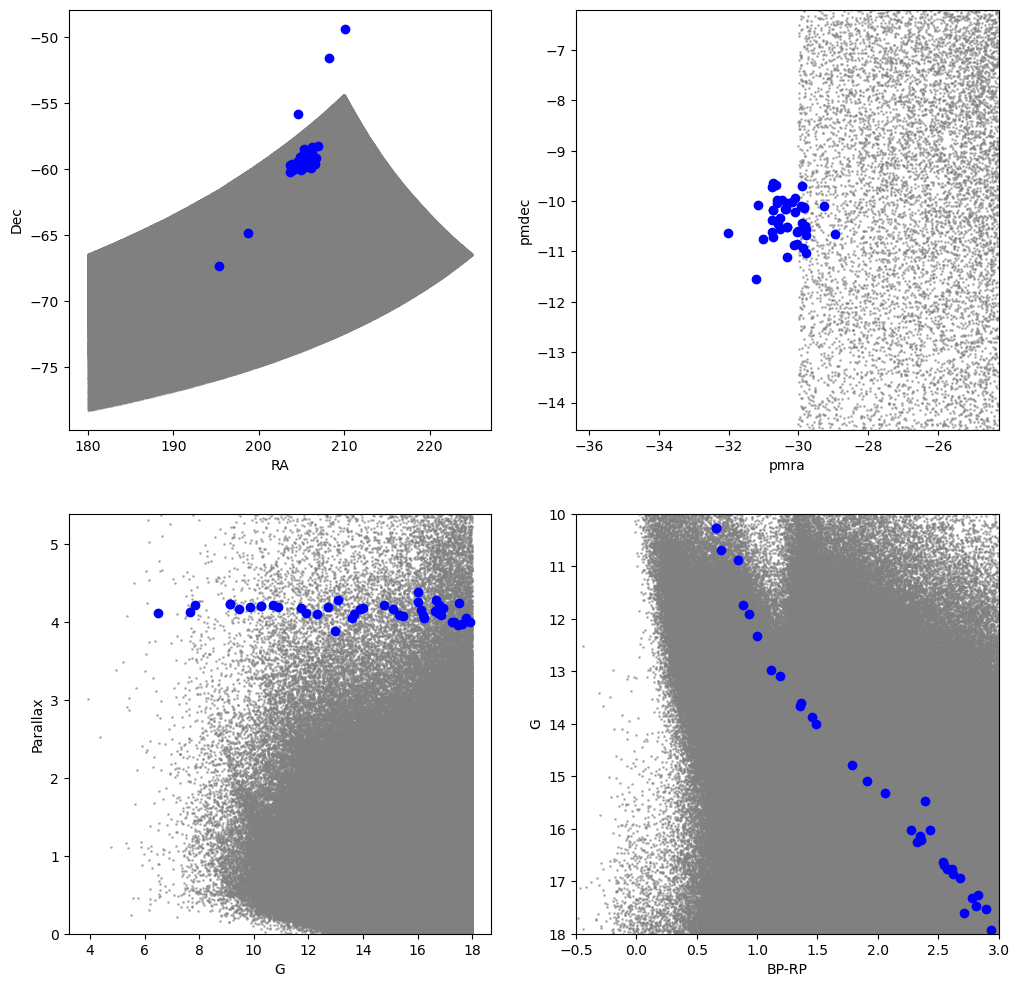

G <= 12.0
	OC members: 13
	Field stars: 48872
	# HDBscan Groups: 48
0.0
	Purity: 0
	Completeness: 0.0
G <= 13.0
	OC members: 16
	Field stars: 136262
	# HDBscan Groups: 126
0.0
	Purity: 0
	Completeness: 0.0
G <= 14.0
	OC members: 20
	Field stars: 351438
	# HDBscan Groups: 318
		Group 1:
			 # members: 20
			 # crossmatched stars: 4
20.0
	Purity: 0.2
	Completeness: 0.2
G <= 15.0
	OC members: 22
	Field stars: 852340
	# HDBscan Groups: 694
		Group 1:
			 # members: 21
			 # crossmatched stars: 4
21.0
	Purity: 0.19047619047619047
	Completeness: 0.18181818181818182
G <= 16.0
	OC members: 25
	Field stars: 1928223
	# HDBscan Groups: 1534
		Group 2:
			 # members: 28
			 # crossmatched stars: 5
28.0
	Purity: 0.17857142857142858
	Completeness: 0.2
G <= 17.0
	OC members: 36
	Field stars: 4146798
	# HDBscan Groups: 3465
		Group 8:
			 # members: 32
			 # crossmatched stars: 7
32.0
	Purity: 0.21875
	Completeness: 0.19444444444444445
G <= 18.0
	OC members: 43
	Field stars: 8450271
	# HDBscan Groups:

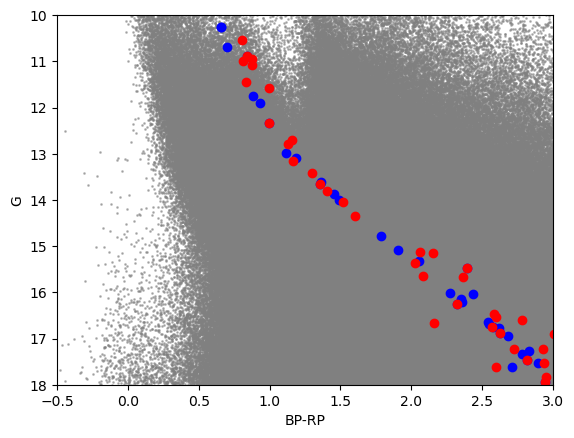

KeyboardInterrupt: 

In [53]:
purityPlatais, completenessPlatais = ClusterAndCrossmatch(field_Platais10, mean_dr3, memb_dr3, 'Platais_10', doclust=False)

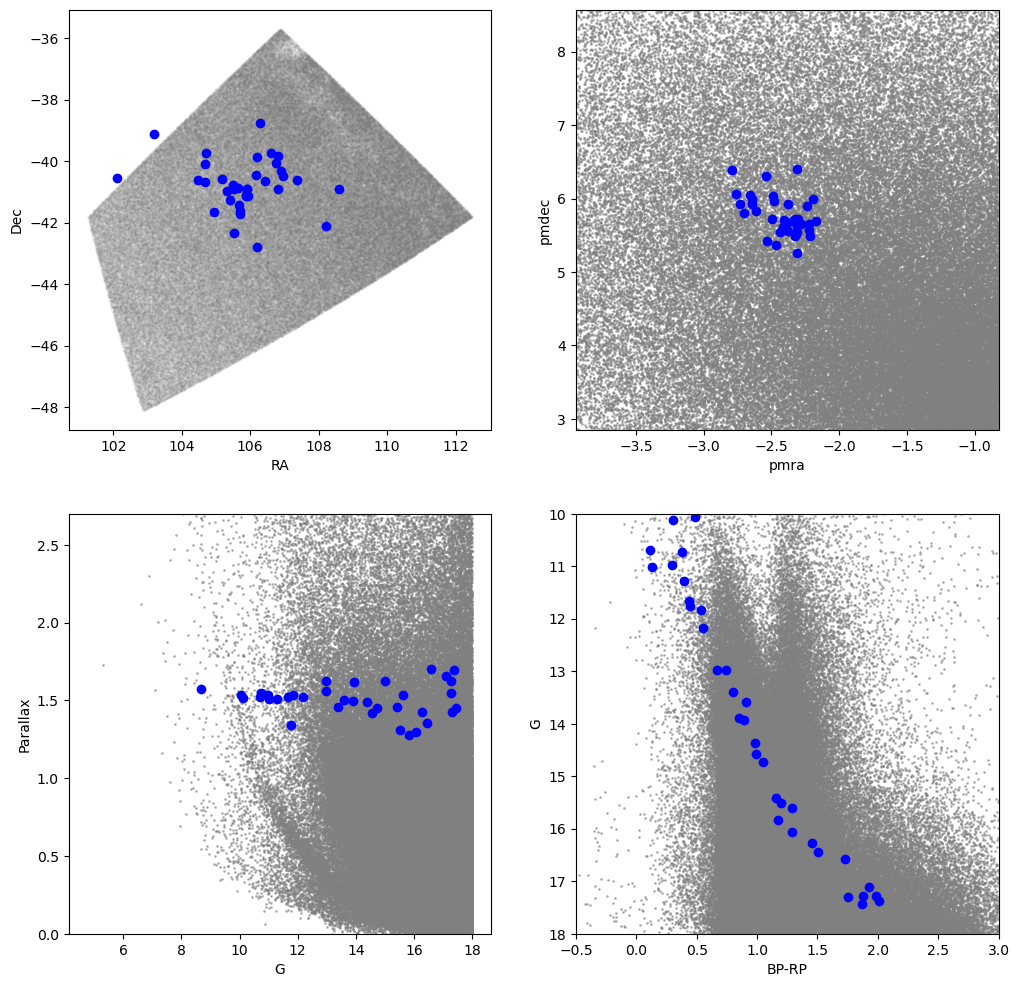

G <= 12.0
	OC members: 11
	Field stars: 4753
	# HDBscan Groups: 8
		Group 1:
			 # members: 17
			 # crossmatched stars: 8
17.0
	Purity: 0.47058823529411764
	Completeness: 0.7272727272727273
G <= 13.0
	OC members: 14
	Field stars: 11081
	# HDBscan Groups: 12
		Group 1:
			 # members: 33
			 # crossmatched stars: 10
33.0
	Purity: 0.30303030303030304
	Completeness: 0.7142857142857143
G <= 14.0
	OC members: 18
	Field stars: 24843
	# HDBscan Groups: 22
		Group 1:
			 # members: 24
			 # crossmatched stars: 12
24.0
	Purity: 0.5
	Completeness: 0.6666666666666666
G <= 15.0
	OC members: 21
	Field stars: 52881
	# HDBscan Groups: 35
		Group 4:
			 # members: 23
			 # crossmatched stars: 13
23.0
	Purity: 0.5652173913043478
	Completeness: 0.6190476190476191
G <= 16.0
	OC members: 26
	Field stars: 105876
	# HDBscan Groups: 61
		Group 2:
			 # members: 27
			 # crossmatched stars: 13
27.0
	Purity: 0.48148148148148145
	Completeness: 0.5
G <= 17.0
	OC members: 30
	Field stars: 198915
	# HDBscan Groups

In [ ]:
purityUPK495, completenessUPK459 = ClusterAndCrossmatch(field_UPK495, mean_dr3, memb_dr3, 'UPK_495', doclust=False)

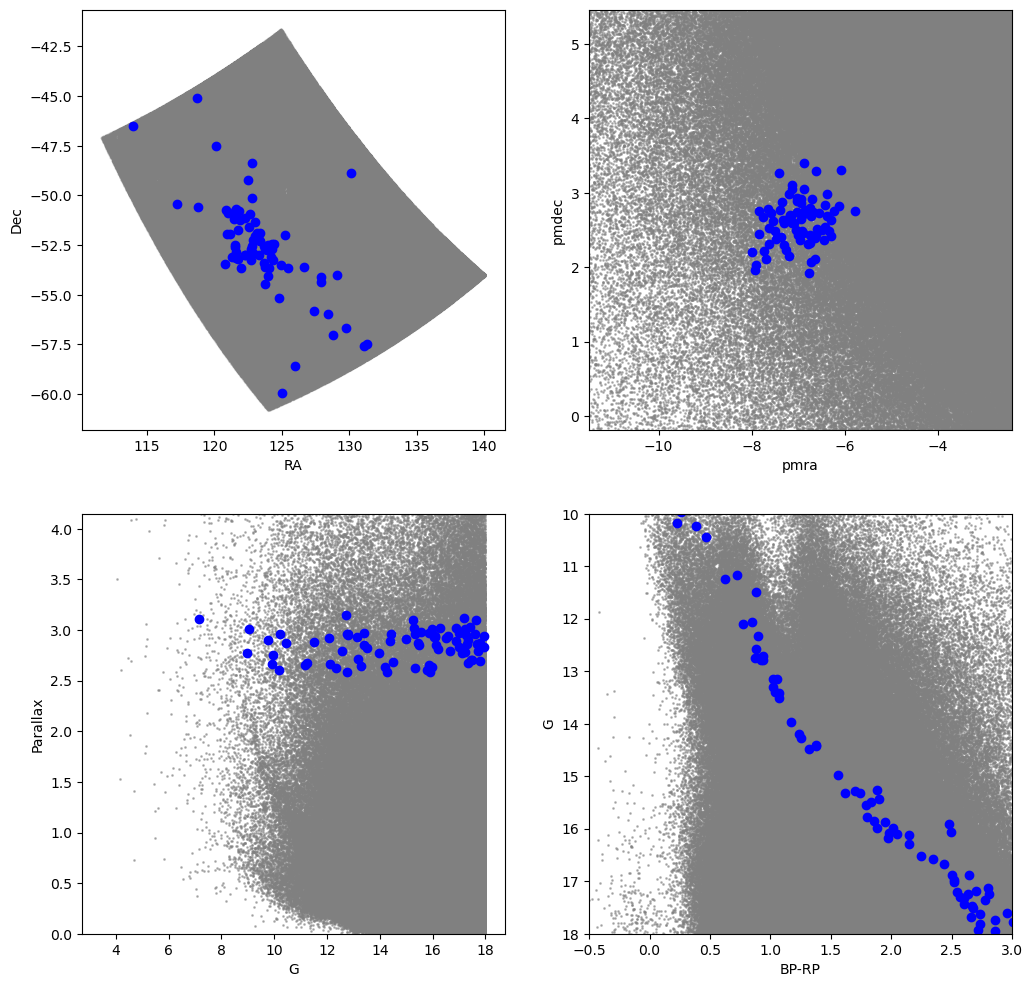

G <= 12.0
	OC members: 12
	Field stars: 24460
	# HDBscan Groups: 38
		Group 5:
			 # members: 87
			 # crossmatched stars: 1
87.0
	Purity: 0.011494252873563218
	Completeness: 0.08333333333333333
G <= 13.0
	OC members: 21
	Field stars: 59624
	# HDBscan Groups: 74
		Group 3:
			 # members: 11
			 # crossmatched stars: 4
		Group 9:
			 # members: 106
			 # crossmatched stars: 1
117.0
	Purity: 0.042735042735042736
	Completeness: 0.23809523809523808
G <= 14.0
	OC members: 28
	Field stars: 138217
	# HDBscan Groups: 133
		Group 1:
			 # members: 24
			 # crossmatched stars: 1
		Group 9:
			 # members: 150
			 # crossmatched stars: 1
174.0
	Purity: 0.011494252873563218
	Completeness: 0.07142857142857142
G <= 15.0
	OC members: 34
	Field stars: 306996
	# HDBscan Groups: 275
		Group 5:
			 # members: 61
			 # crossmatched stars: 6
		Group 8:
			 # members: 17
			 # crossmatched stars: 14
		Group 14:
			 # members: 195
			 # crossmatched stars: 1
273.0
	Purity: 0.07692307692307693
	Completeness: 0

In [ ]:
purityUPK533, completenessUPK533 = ClusterAndCrossmatch(field_UPK533, mean_dr3, memb_dr3, 'UPK_533', doclust=False)

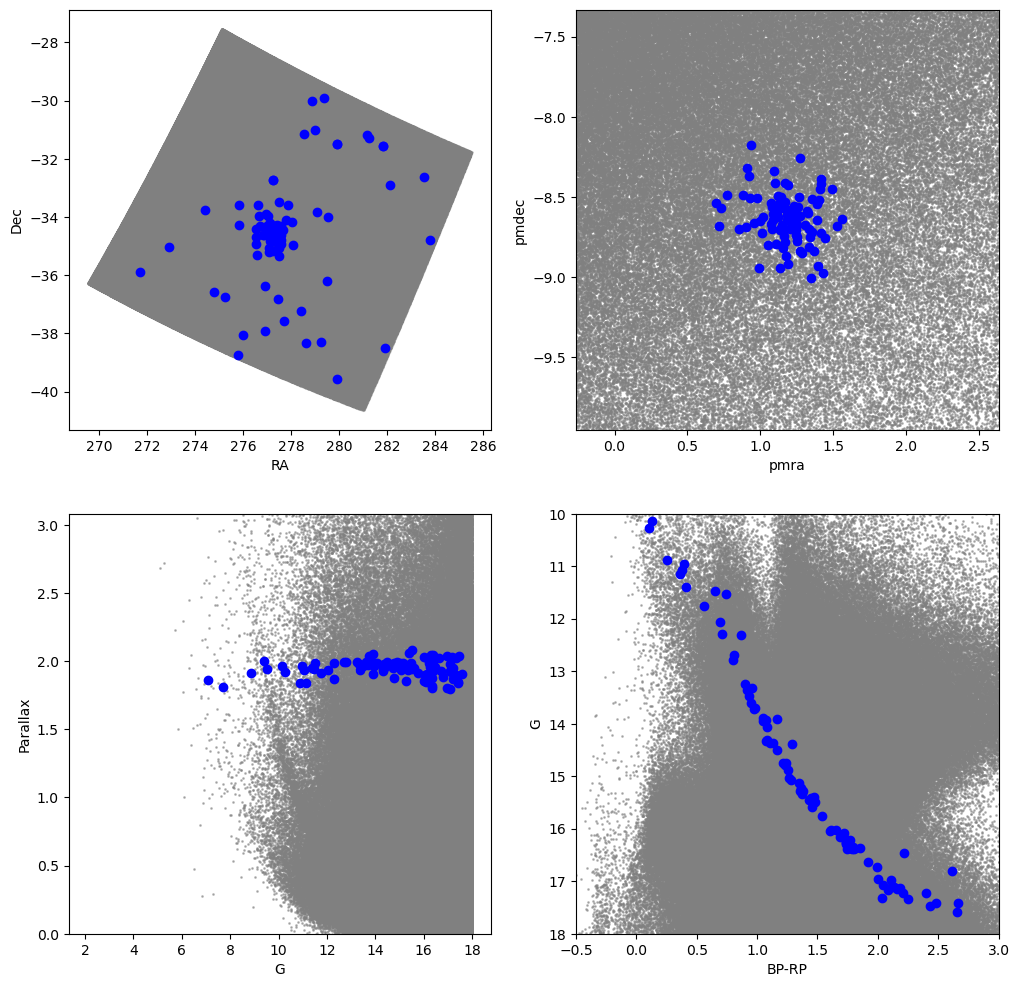

G <= 12.0
	OC members: 15
	Field stars: 21719
	# HDBscan Groups: 21
		Group 1:
			 # members: 14
			 # crossmatched stars: 9
14.0
	Purity: 0.6428571428571429
	Completeness: 0.6
G <= 13.0
	OC members: 20
	Field stars: 69199
	# HDBscan Groups: 64
		Group 2:
			 # members: 20
			 # crossmatched stars: 13
20.0
	Purity: 0.65
	Completeness: 0.65
G <= 14.0
	OC members: 31
	Field stars: 199115
	# HDBscan Groups: 204
		Group 3:
			 # members: 29
			 # crossmatched stars: 19
29.0
	Purity: 0.6551724137931034
	Completeness: 0.6129032258064516
G <= 15.0
	OC members: 42
	Field stars: 513367
	# HDBscan Groups: 586
		Group 4:
			 # members: 36
			 # crossmatched stars: 26
36.0
	Purity: 0.7222222222222222
	Completeness: 0.6190476190476191
G <= 16.0
	OC members: 56
	Field stars: 1313260
	# HDBscan Groups: 1502
		Group 6:
			 # members: 44
			 # crossmatched stars: 32
44.0
	Purity: 0.7272727272727273
	Completeness: 0.5714285714285714
G <= 17.0
	OC members: 83
	Field stars: 2566047
	# HDBscan Groups: 2917

In [ ]:
purityUPK654, completenessUPK654 = ClusterAndCrossmatch(field_UPK654, mean_dr3, memb_dr3, 'UPK_654', doclust=False)

In [ ]:
magnitudecutsUBC21 = np.arange(12, (np.ceil(np.max(memb_dr3.query('cluster == "UBC_21"')['phot_g_mean_mag'])) + 1))
magnitudecutsUBC13 = np.arange(12, (np.ceil(np.max(memb_dr3.query('cluster == "UBC_13"')['phot_g_mean_mag'])) + 1))
magnitudecutsUBC14 = np.arange(12, (np.ceil(np.max(memb_dr3.query('cluster == "UBC_14"')['phot_g_mean_mag'])) + 1))
magnitudecutsCOIN = np.arange(12, (np.ceil(np.max(memb_dr3.query('cluster == "COIN-Gaia_13"')['phot_g_mean_mag'])) + 1))
magnitudecutsPlatais = np.arange(12, (np.ceil(np.max(memb_dr3.query('cluster == "Platais_10"')['phot_g_mean_mag'])) + 1))
magnitudecutsUPK495 = np.arange(12, (np.ceil(np.max(memb_dr3.query('cluster == "UPK_495"')['phot_g_mean_mag'])) + 1))
magnitudecutsUPK533 = np.arange(12, (np.ceil(np.max(memb_dr3.query('cluster == "UPK_533"')['phot_g_mean_mag'])) + 1))
magnitudecutsUPK654 = np.arange(12, (np.ceil(np.max(memb_dr3.query('cluster == "UPK_654"')['phot_g_mean_mag'])) + 1))

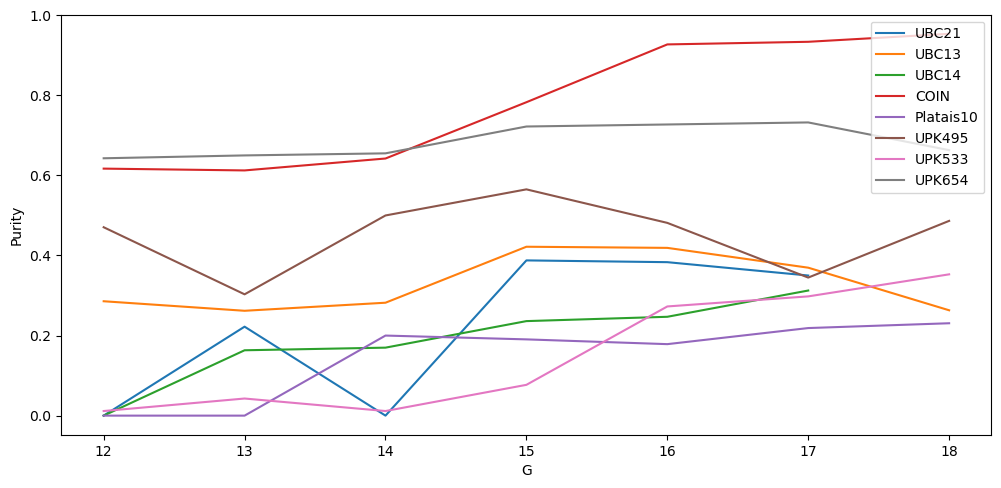

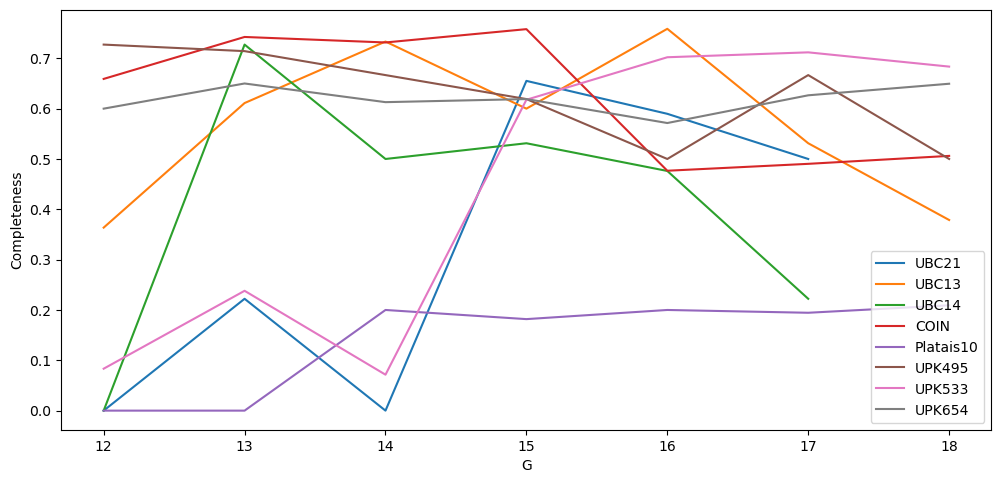

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.plot(magnitudecutsUBC21, purity21, label = 'UBC21')
plt.plot(magnitudecutsUBC13, purity13, label = 'UBC13')
plt.plot(magnitudecutsUBC14, purity14, label = 'UBC14')
plt.plot(magnitudecutsCOIN, purityCOIN, label = 'COIN')
plt.plot(magnitudecutsPlatais, purityPlatais, label = 'Platais10')
plt.plot(magnitudecutsUPK495, purityUPK495, label = 'UPK495')
plt.plot(magnitudecutsUPK533, purityUPK533, label = 'UPK533')
plt.plot(magnitudecutsUPK654, purityUPK654, label = 'UPK654')
plt.legend()
plt.xlabel('G')
plt.ylabel('Purity')
plt.show()
plt.figure(figsize=(12,12))
plt.subplot(2,1,2)
plt.plot(magnitudecutsUBC21, completeness21, label = 'UBC21')
plt.plot(magnitudecutsUBC13, completeness13, label = 'UBC13')
plt.plot(magnitudecutsUBC14, completeness14, label = 'UBC14')
plt.plot(magnitudecutsCOIN, completenessCOIN, label = 'COIN')
plt.plot(magnitudecutsPlatais, completenessPlatais, label = 'Platais10')
plt.plot(magnitudecutsUPK495, completenessUPK459, label = 'UPK495')
plt.plot(magnitudecutsUPK533, completenessUPK533, label = 'UPK533')
plt.plot(magnitudecutsUPK654, completenessUPK654, label = 'UPK654')
plt.legend()
plt.xlabel('G')
plt.ylabel('Completeness')
plt.show()

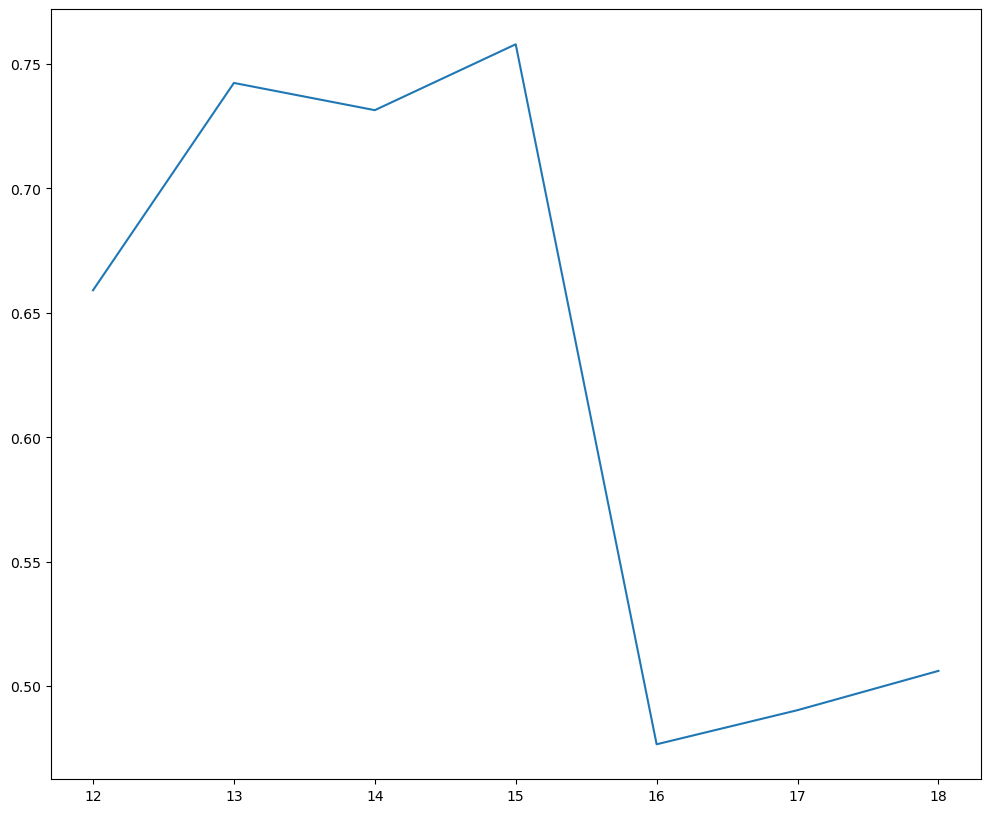

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(magnitudecutsCOIN, completenessCOIN, label = 'COIN')